# Universidad de Buenos Aires
# NLP - Examen
Sentiment analysis from movies comments

In [ ]:
from numpy import array
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/UBA IA 2020/9-NLP/colab')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('data/IMDB Dataset.csv')

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# create vocabulary
# https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html
# https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/

In [ ]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def evaluar_modelo(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()
    #y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]
    mask_positive = y_hat_prob >= 0.5
    mask_negative = y_hat_prob < 0.5
    y_hat = y_hat_prob
    y_hat[mask_positive] = 1
    y_hat[mask_negative] = 0
    y_hat = y_hat.astype(int)

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

In [ ]:
import logging

import os
from pathlib import Path
from io import StringIO
import pickle

from pathlib import Path
from io import StringIO
import pickle

import numpy as np


#logging.basicConfig(level=logging.DEBUG)


class WordsEmbeddings(object):

    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            print("Saving PKL", bytes_out)
            # for idx in range(0, len(bytes_out), max_bytes):
            #     f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

## Limpieza de datos

In [ ]:
# EN los datos se observó código de HTML de salto de línea <br />
import re    
sentences = data['review'].apply(lambda x: re.sub("<br />", "", x))
sentences.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. The filming tec...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [ ]:
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
y.shape

(50000,)

## 1 - Bag of words with scikit-learn

In [ ]:
# Por defecto CountVectorizer elimina los signos de puntuacion y transforma
# todas las palabras a lowercase
# max_features --> limitacion la máxima dimensión del oneHotEncoding
# stop_words --> quitamos aquellas palabras que para el idioma se consideran
# relevantes (como los árticulos, pronombres, preposiciones, adverbios, etc)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(sentences)

In [ ]:
X = X.toarray()
X.shape

(50000, 2000)

#### PCA

In [ ]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=50).fit_transform(X)

#### Preparar los datos

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#### Entrenar el modelo (clasico DNN)

In [ ]:
in_shape = X_train.shape[1]
in_shape

50

In [ ]:
out_shape = 1

In [ ]:
from keras.layers import Dense, Dropout
model1 = Sequential()

dropout_rate = 0.5

model1.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model1.add(Dropout(rate=0.3))
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(rate=dropout_rate))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dropout(rate=dropout_rate))
model1.add(Dense(units=out_shape, activation='sigmoid'))

model1.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [ ]:
history1 = model1.fit(X_train, y_train, validation_split=0.2 , epochs=20, batch_size=200)

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 0.6365 - accuracy: 0.6352 - val_loss: 0.5000 - val_accuracy: 0.7717
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.5278 - accuracy: 0.7500 - val_loss: 0.4771 - val_accuracy: 0.7805
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7625 - val_loss: 0.4704 - val_accuracy: 0.7857
Epoch 4/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4948 - accuracy: 0.7702 - val_loss: 0.4650 - val_accuracy: 0.7871
Epoch 5/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.7722 - val_loss: 0.4603 - val_accuracy: 0.7903
Epoch 6/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4848 - accuracy: 0.7751 - val_loss: 0.4606 - val_accuracy: 0.7880
Epoch 7/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.7799 - val_loss: 0.4570 - val_accuracy: 0.7866
Epoch 

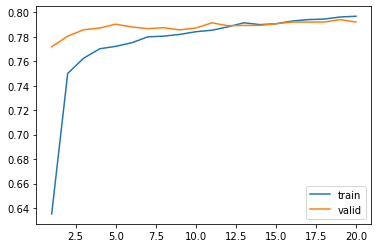

In [ ]:
plot_train_metrics(history1)

#### Evaluar el modelo

313/313 [==============================] - 0s 1ms/step - loss: 0.4463 - accuracy: 0.7899
Accuracy: 0.789900004863739
auc_keras 0.7899956433349404


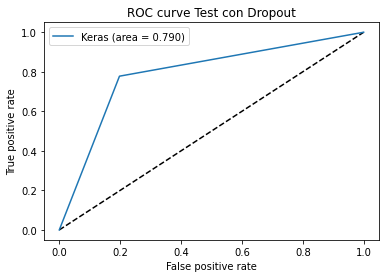

In [ ]:
evaluar_modelo(model1, X_test, y_test)

## 1B - Tfid con scikit-learn

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(sentences)

In [ ]:
X = X.toarray()
X.shape

(50000, 2000)

In [ ]:
# PCA
from sklearn.decomposition import PCA
X_pca = PCA(n_components=50).fit_transform(X)

In [ ]:
# Preparar los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
# Entrenar el modelo
in_shape = X_train.shape[1]
out_shape = 1
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 50 , out_shape 1


In [ ]:
from keras.layers import Dense, Dropout
model1b = Sequential()

dropout_rate = 0.5

model1b.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model1b.add(Dropout(rate=0.3))
model1b.add(Dense(units=64, activation='relu'))
model1b.add(Dropout(rate=dropout_rate))
model1b.add(Dense(units=32, activation='relu'))
model1b.add(Dropout(rate=dropout_rate))
model1b.add(Dense(units=out_shape, activation='sigmoid'))

model1b.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 0.5266 - accuracy: 0.7436 - val_loss: 0.3719 - val_accuracy: 0.8363
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4001 - accuracy: 0.8304 - val_loss: 0.3665 - val_accuracy: 0.8357
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3869 - accuracy: 0.8343 - val_loss: 0.3628 - val_accuracy: 0.8369
Epoch 4/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3811 - accuracy: 0.8369 - val_loss: 0.3610 - val_accuracy: 0.8390
Epoch 5/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3744 - accuracy: 0.8390 - val_loss: 0.3615 - val_accuracy: 0.8349
Epoch 6/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3711 - accuracy: 0.8411 - val_loss: 0.3581 - val_accuracy: 0.8380
Epoch 7/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.8428 - val_loss: 0.3570 - val_accuracy: 0.8395
Epoch 

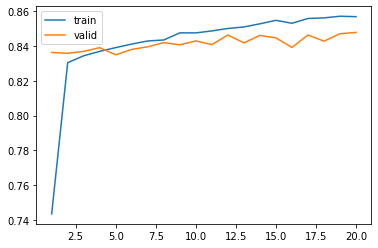

In [ ]:
history1b = model1b.fit(X_train, y_train, validation_split=0.2 , epochs=20, batch_size=200)
plot_train_metrics(history1b)

313/313 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8467
Accuracy: 0.8467000126838684
auc_keras 0.846471479324802


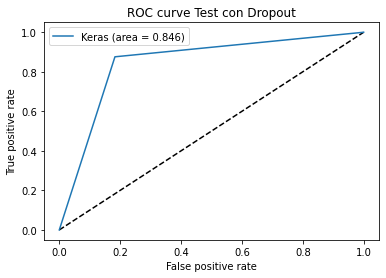

In [ ]:
evaluar_modelo(model1b, X_test, y_test)

## 2 - Embedding de oraciones con Glove

In [ ]:
glove_model = GloveEmbeddings()

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

for i in range(len(sentences)):
    # Tokenizar la sentencia, quitar los signos de puntuacion y dejar todo en minisculas
    bow = tokenizer.tokenize(str.lower(sentences.loc[i]))
    word_embeddings = glove_model.get_words_embeddings(bow)
    
    sentence_embedding = word_embeddings.mean(axis=0).reshape(1, 50)
    if i == 0:
        X = sentence_embedding
    else:
        X = np.append(X, sentence_embedding, axis=0)
    # print(bow)
    # print(len(bow))
    # print(word_embeddings[0])
    # print(word_embeddings.shape)
    #print(sentence_embedding.shape)

In [ ]:
X.shape

(50000, 50)

In [ ]:
# Preparar los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Entrenar el modelo
in_shape = X_train.shape[1]
out_shape = 1
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 50 , out_shape 1


In [ ]:
from keras.layers import Dense, Dropout
model2 = Sequential()

dropout_rate = 0.5

model2.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(rate=dropout_rate))
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(rate=dropout_rate))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 0.6809 - accuracy: 0.5590 - val_loss: 0.5992 - val_accuracy: 0.7106
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.5620 - accuracy: 0.7227 - val_loss: 0.4925 - val_accuracy: 0.7661
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.5080 - accuracy: 0.7653 - val_loss: 0.4713 - val_accuracy: 0.7790
Epoch 4/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4963 - accuracy: 0.7726 - val_loss: 0.4717 - val_accuracy: 0.7740
Epoch 5/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.7763 - val_loss: 0.4617 - val_accuracy: 0.7878
Epoch 6/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4857 - accuracy: 0.7783 - val_loss: 0.4549 - val_accuracy: 0.7880
Epoch 7/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.7803 - val_loss: 0.4529 - val_accuracy: 0.7889
Epoch 

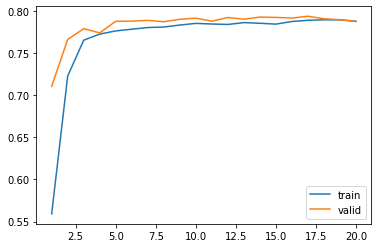

In [ ]:
history2 = model2.fit(X_train, y_train, validation_split=0.2 , epochs=20, batch_size=200)
plot_train_metrics(history2)

313/313 [==============================] - 0s 1ms/step - loss: 0.4489 - accuracy: 0.7891
Accuracy: 0.7890999913215637
auc_keras 0.789426488707573


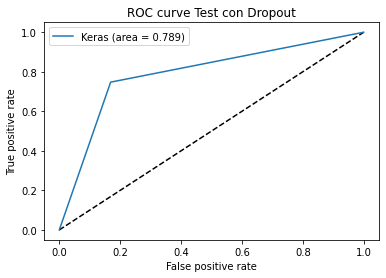

In [ ]:
evaluar_modelo(model2, X_test, y_test)

## 2B - Embedding de oraciones con Fasttext

In [ ]:
fasttext_model = FasttextEmbeddings()

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

for i in range(len(sentences)):
    # Tokenizar la sentencia, quitar los signos de puntuacion y dejar todo en minisculas
    bow = tokenizer.tokenize(str.lower(sentences.loc[i]))
    word_embeddings = fasttext_model.get_words_embeddings(bow)
    sentence_embedding = word_embeddings.mean(axis=0).reshape(1, 300)
    if i == 0:
        X = sentence_embedding
    else:
        X = np.append(X, sentence_embedding, axis=0)

In [ ]:
X.shape

(50000, 300)

In [ ]:
# Preparar los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

in_shape = X_train.shape[1]
out_shape = 1
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 300 , out_shape 1


In [ ]:
from keras.layers import Dense, Dropout
model2b = Sequential()

dropout_rate = 0.5

model2b.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model2b.add(Dropout(rate=0.3))
model2b.add(Dense(units=64, activation='relu'))
model2b.add(Dropout(rate=dropout_rate))
model2b.add(Dense(units=32, activation='relu'))
model2b.add(Dropout(rate=dropout_rate))
model2b.add(Dense(units=out_shape, activation='sigmoid'))

model2b.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               38528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

Epoch 1/20
160/160 [==============================] - 4s 13ms/step - loss: 0.6699 - accuracy: 0.5754 - val_loss: 0.4954 - val_accuracy: 0.7759
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.7727 - val_loss: 0.4317 - val_accuracy: 0.8051
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4452 - accuracy: 0.8031 - val_loss: 0.4121 - val_accuracy: 0.8150
Epoch 4/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4248 - accuracy: 0.8196 - val_loss: 0.3957 - val_accuracy: 0.8242
Epoch 5/20
160/160 [==============================] - 0s 3ms/step - loss: 0.4179 - accuracy: 0.8205 - val_loss: 0.3947 - val_accuracy: 0.8254
Epoch 6/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3997 - accuracy: 0.8307 - val_loss: 0.3832 - val_accuracy: 0.8301
Epoch 7/20
160/160 [==============================] - 0s 3ms/step - loss: 0.3920 - accuracy: 0.8334 - val_loss: 0.3666 - val_accuracy: 0.8370
Epoch

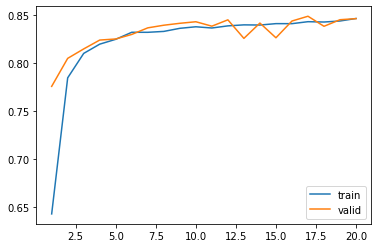

In [ ]:
history2b = model2b.fit(X_train, y_train, validation_split=0.2 , epochs=20, batch_size=200)
plot_train_metrics(history2b)

313/313 [==============================] - 1s 2ms/step - loss: 0.3539 - accuracy: 0.8440
Accuracy: 0.843999981880188
auc_keras 0.8437627345247685


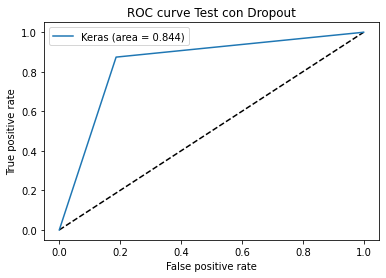

In [ ]:
evaluar_modelo(model2b, X_test, y_test)

## 3 - Embedding + LTSM

In [ ]:
# Ejemplos en el uso de las libreria de keras
# https://www.onceupondata.com/2019/01/21/keras-text-part1/

In [ ]:
# Conctenar todas las sentencias
corpus = ' '.join(sentences.values)
len(corpus)

64309862

In [ ]:
# Separar las palabras por coma, quitar los signos de puntuacion y pasar a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Cantidad de palabras en el curpus (sin signos de puntuacion)
len(tokens)

11546955

In [ ]:
# Tokenizamos las palabras
from keras.preprocessing.text import Tokenizer
num_words = 2000
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens) 

In [ ]:
vocab_size = len(tok.word_counts)
vocab_size

126512

In [ ]:
vocab_size = num_words
vocab_size

2000

In [ ]:
# convertimos las palabras a números
max_word_vect_size = 0
word_vect_corpus = []
for sequence in sentences.values:
    word_sequence = text_to_word_sequence(sequence)
    list_word_vect_indx = tok.texts_to_sequences(word_sequence)
    word_vect_indx = [x[0] for x in list_word_vect_indx if x]
    if len(word_vect_indx) > max_word_vect_size:
        max_word_vect_size = len(word_vect_indx)
    word_vect_corpus.append(word_vect_indx)
print("Oracion vectorizada más larga:", max_word_vect_size)

Oracion vectorizada más larga: 1853


In [ ]:
# Padding de las sentencias al mismo tamaño
maxlen = 200 # None --> padding al amx
from keras.preprocessing.sequence import pad_sequences
pad_word_vect_corpus = pad_sequences(word_vect_corpus, padding='post', maxlen=maxlen)

In [ ]:
pad_word_vect_corpus.shape

(50000, 200)

In [ ]:
# Preparar los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pad_word_vect_corpus, y, test_size=0.2, random_state=42)

In [ ]:
in_shape = X_train.shape[1]
out_shape = 1
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 200 , out_shape 1


In [ ]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LeakyReLU

model3 = Sequential()
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 3 --> crear embeddings de tamaño 3
model3.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model3.add(LSTM(units=64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

# model3.add(Dense(units=128, activation='relu'))
# model3.add(Dropout(rate=0.3))
# model3.add(Dense(units=64, activation='relu'))
# model3.add(Dropout(rate=0.5))
# model3.add(Dense(units=32, activation='relu'))
# model3.add(Dropout(rate=0.5))
# model3.add(Dense(units=out_shape, activation='sigmoid'))

model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='sigmoid'))

model3.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           100050    
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 64)           29440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Epoch 1/5
3200/3200 [==============================] - 61s 18ms/step - loss: 0.6950 - accuracy: 0.5018 - val_loss: 0.6922 - val_accuracy: 0.5019
Epoch 2/5
3200/3200 [==============================] - 59s 18ms/step - loss: 0.6923 - accuracy: 0.5071 - val_loss: 0.6905 - val_accuracy: 0.5058
Epoch 3/5
3200/3200 [==============================] - 59s 18ms/step - loss: 0.6871 - accuracy: 0.5172 - val_loss: 0.6235 - val_accuracy: 0.6557
Epoch 4/5
3200/3200 [==============================] - 57s 18ms/step - loss: 0.5931 - accuracy: 0.6785 - val_loss: 0.3431 - val_accuracy: 0.8569
Epoch 5/5
3200/3200 [==============================] - 57s 18ms/step - loss: 0.3306 - accuracy: 0.8632 - val_loss: 0.3113 - val_accuracy: 0.8696


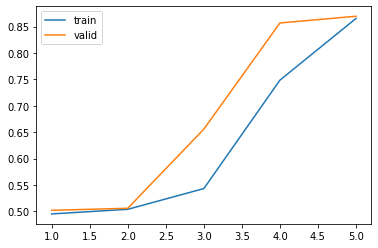

In [ ]:
history3 = model3.fit(X_train, y_train, validation_split=0.2 , epochs=5, batch_size=10)
plot_train_metrics(history3)

313/313 [==============================] - 3s 9ms/step - loss: 0.2981 - accuracy: 0.8763
Accuracy: 0.8762999773025513
auc_keras 0.8759859149830675


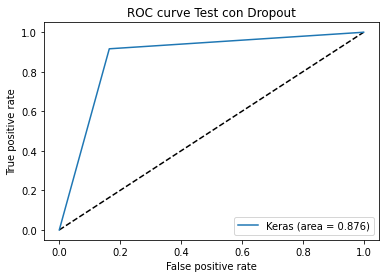

In [ ]:
evaluar_modelo(model3, X_test, y_test)

## 4 - BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 8.0MB/s 
     |████████████████████████████████| 890kB 37.4MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6098b672d08dd28883169a3816b8bbb316f8ce1aa86282c36279039b68bacf77
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
bert_max_length = 200
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

32000 8000 10000


In [ ]:
import tensorflow as tf
def convert_data_to_examples(text, labels, idx_train, idx_val): 
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text.iloc[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text.iloc[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=200):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=bert_max_length)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=bert_max_length)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
pred_sentences = sentences.loc[idx_test].values
tf_batch = bert_tokenizer(pred_sentences.tolist(), max_length=bert_max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
test_inputs = [tf_batch['input_ids'], 
          tf_batch['token_type_ids'], 
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

## 4a - BERT sin Fine tuning

In [ ]:
model_bert_1 = bert_model
model_bert_1.bert.trainable = False
model_bert_1.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________


In [ ]:
model_bert_1.compile(tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history_bert4a = model_bert_1.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efdf0fbce58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efdf0fbce58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


   2000/Unknown - 1080s 523ms/step - loss: 0.6907 - accuracy: 0.5279

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2000/2000 [==============================] - 1204s 585ms/step - loss: 0.6907 - accuracy: 0.5279 - val_loss: 0.6567 - val_accuracy: 0.6447
Epoch 2/3
2000/2000 [==============================] - 1171s 585ms/step - loss: 0.6532 - accuracy: 0.6471 - val_loss: 0.6285 - val_accuracy: 0.6806
Epoch 3/3
2000/2000 [==============================] - 1170s 585ms/step - loss: 0.6291 - accuracy: 0.6753 - val_loss: 0.6095 - val_accuracy: 0.6929


In [ ]:
tf_outputs = model_bert_1.predict(test_inputs)
y_hat_prob = tf.nn.softmax(tf_outputs[0], axis=-1)
y_hat_prob_sigmoid = y_hat_prob[:, 1]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


auc_keras 0.7062840303204045


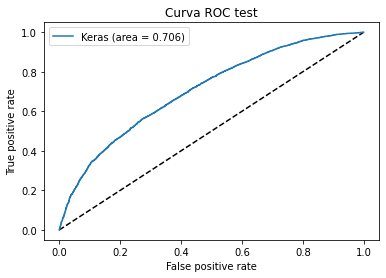

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob_sigmoid)
auc_keras = auc(fpr, tpr)
print('auc_keras', auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC test')
plt.legend(loc='best')
plt.show()

## 4b - BERT con Fine tuning

In [ ]:
model_bert_2 = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

model_bert_2.compile(tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history_bert4b = model_bert_2.fit(train_data, epochs=1, validation_data=validation_data)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will a

   2000/Unknown - 2711s 1s/step - loss: 0.2896 - accuracy: 0.8759

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2000/2000 [==============================] - 2826s 1s/step - loss: 0.2896 - accuracy: 0.8759 - val_loss: 0.2540 - val_accuracy: 0.9134


In [ ]:
tf_outputs = model_bert_2.predict(test_inputs)
y_hat_prob = tf.nn.softmax(tf_outputs[0], axis=-1)
y_hat_prob_sigmoid = y_hat_prob[:, 1]

(10000, 2)
(10000, 2)
auc_keras 0.9704147000303498


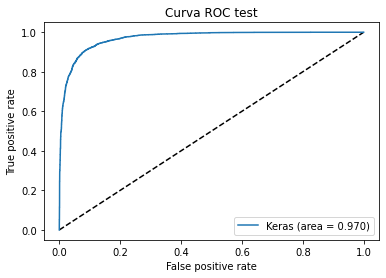

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob_sigmoid)
auc_keras = auc(fpr, tpr)
print('auc_keras', auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC test')
plt.legend(loc='best')
plt.show()

## Resultados y conclusiones
Tabla de resultados:

| Algorithm                 | RUC Accuracy|
|---------------------------|-------------|
| 1a) BOW (OneHotEncoding)  | 0.789  |
| 1b) BOW (TFIDF)           | 0.844  |
| 2a) Embeddings (Glove)    | 0.789  |
| 2b) Embeddings (Fastttext)| 0.843  |
| 3) LSTM                   | 0.875  |
| 4a) BERT                   | 0.706  |
| 4b) BERT + Fine-Tuning     | 0.970  |

Se puede apreciar que a medida que se utilizaron tecnologías "más mordernas" para la resolución del problema el accuracy fue mejorando. 
- En el caso de los embeddings pre enternados (GLobe y Fasttext) no dió un resultado superador respecto a BOW tradicional debido a que se realizó una promediado de los embeddings para su uso en la red.
- En el caso de LSTM costó bastante poder entrenar la red, hubo que probar bastantes combinaciones hasta dar con la acertada y el resultado se refleja en su accuracy, superando los otros métodos.
- BERT, como era de esperarse, fue superador ampliamente en el proceso de Fine-Tuning. El proceso normal (sin Fine-Tuning) no alcanzó un accuracy sobresaliente, pero tampoco se realizaron demasaidos épocas para ver como podría evolucionar el accuracy (parece que aún podría seguir aprendiendo con más épocas).